<a href="https://colab.research.google.com/github/Alexander1718/UIDAI-HACKATHON/blob/main/01_data_ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import pandas as pd
from glob import glob

pd.set_option("display.max_columns", None)


In [ ]:
zip_files = [f for f in os.listdir() if f.endswith(".zip")]
zip_files


['api_data_aadhar_enrolment.zip',
 'api_data_aadhar_biometric.zip',
 'api_data_aadhar_demographic.zip']

In [ ]:
os.makedirs("data", exist_ok=True)

for z in zip_files:
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall("data")

print("ZIP extraction completed successfully.")


ZIP extraction completed successfully.


In [ ]:
def load_all_csvs(folder):
    csv_files = glob(folder + "/**/*.csv", recursive=True)
    return pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

biometric_df   = load_all_csvs("data/api_data_aadhar_biometric")
demographic_df = load_all_csvs("data/api_data_aadhar_demographic")
enrolment_df   = load_all_csvs("data/api_data_aadhar_enrolment")

print("Biometric:", biometric_df.shape)
print("Demographic:", demographic_df.shape)
print("Enrolment:", enrolment_df.shape)


Biometric: (1861108, 6)
Demographic: (2071700, 6)
Enrolment: (1006029, 7)


In [ ]:
def clean(df):
    df.columns = df.columns.str.lower()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df

biometric_df   = clean(biometric_df)
demographic_df = clean(demographic_df)
enrolment_df   = clean(enrolment_df)

biometric_df.head()


/tmp/ipython-input-2663434685.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
/tmp/ipython-input-2663434685.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,2025-07-11,Haryana,Yamuna Nagar,135002,4,6
1,2025-07-11,Haryana,Yamunanagar,135001,1,2
2,2025-07-11,Himachal Pradesh,Bilaspur,174004,2,2
3,2025-07-11,Himachal Pradesh,Bilaspur,174005,1,0
4,2025-07-11,Himachal Pradesh,Bilaspur,174013,3,1


In [ ]:
import matplotlib.pyplot as plt

def plot_missing_values(df, title):
    missing_pct = (df.isna().sum() / len(df)) * 100
    missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

    if missing_pct.empty:
        print(f"No missing values in {title}")
        return

    plt.figure(figsize=(10, 5))
    missing_pct.plot(kind='bar')
    plt.ylabel("Percentage Missing (%)")
    plt.title(f"Missing Data Percentage – {title}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_missing_values(biometric_df, "Biometric Data (Raw)")
plot_missing_values(demographic_df, "Demographic Data (Raw)")
plot_missing_values(enrolment_df, "Enrolment Data (Raw)")


No missing values in Biometric Data (Raw)
No missing values in Demographic Data (Raw)
No missing values in Enrolment Data (Raw)


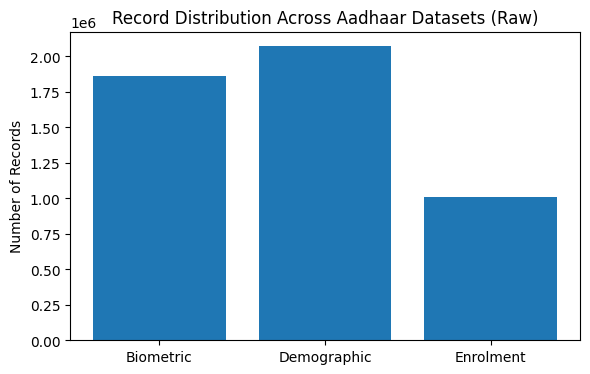

In [ ]:
dataset_sizes = {
    "Biometric": len(biometric_df),
    "Demographic": len(demographic_df),
    "Enrolment": len(enrolment_df)
}

plt.figure(figsize=(6, 4))
plt.bar(dataset_sizes.keys(), dataset_sizes.values())
plt.ylabel("Number of Records")
plt.title("Record Distribution Across Aadhaar Datasets (Raw)")
plt.tight_layout()
plt.show()


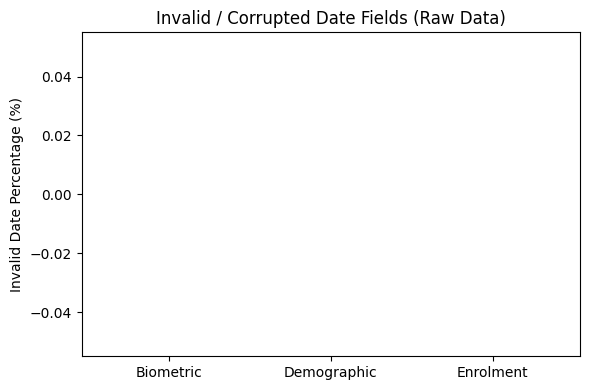

In [ ]:
def invalid_date_ratio(df, name):
    if 'date' not in df.columns:
        return None
    invalid = df['date'].isna().sum()
    return invalid / len(df) * 100

labels = []
values = []

for name, df in [
    ("Biometric", biometric_df),
    ("Demographic", demographic_df),
    ("Enrolment", enrolment_df)
]:
    ratio = invalid_date_ratio(df, name)
    if ratio is not None:
        labels.append(name)
        values.append(ratio)

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel("Invalid Date Percentage (%)")
plt.title("Invalid / Corrupted Date Fields (Raw Data)")
plt.tight_layout()
plt.show()


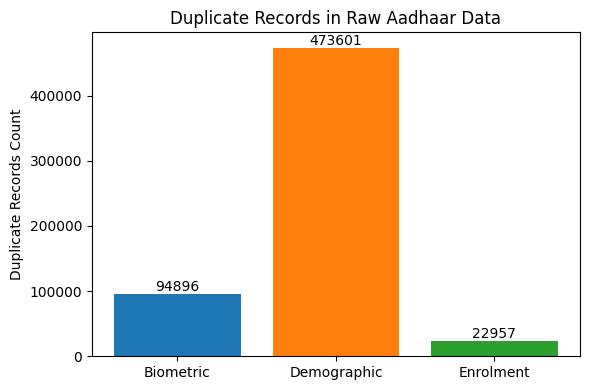

In [ ]:
duplicates = {
    "Biometric": biometric_df.duplicated().sum(),
    "Demographic": demographic_df.duplicated().sum(),
    "Enrolment": enrolment_df.duplicated().sum()
}

labels = list(duplicates.keys())
values = list(duplicates.values())

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green (professional & distinct)

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=colors)

plt.ylabel("Duplicate Records Count")
plt.title("Duplicate Records in Raw Aadhaar Data")

# Add value labels on top of bars (very PPT-friendly)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


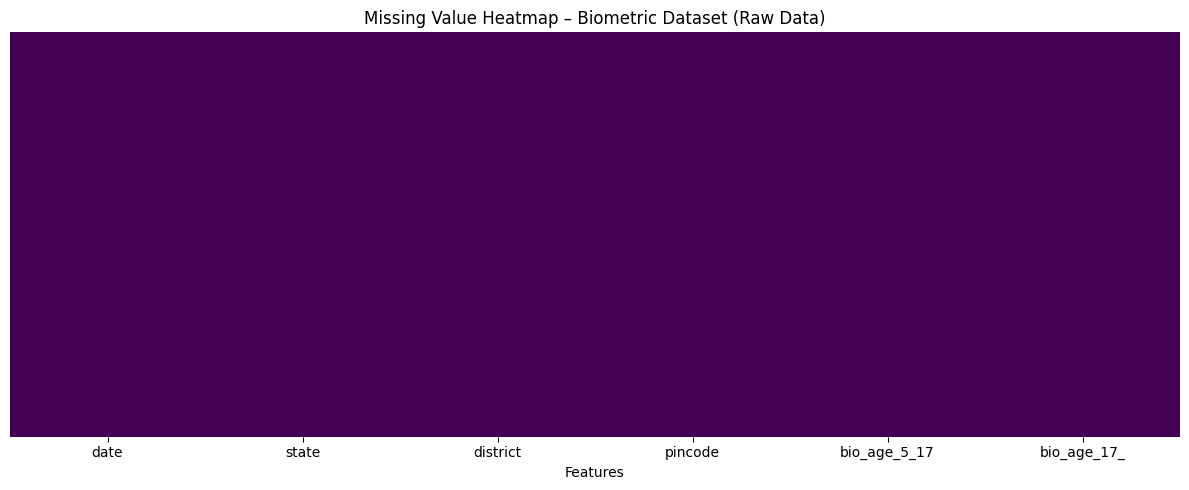

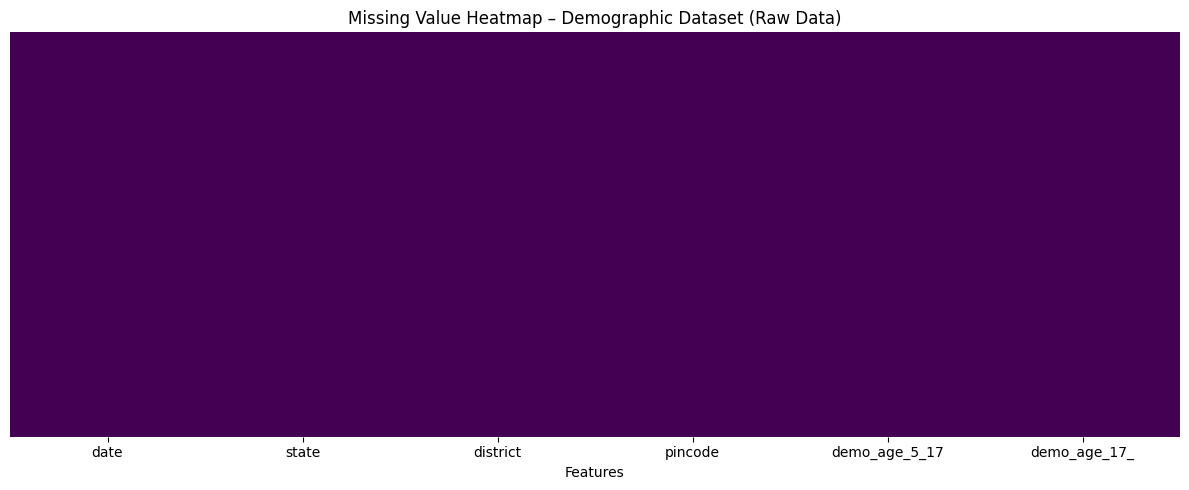

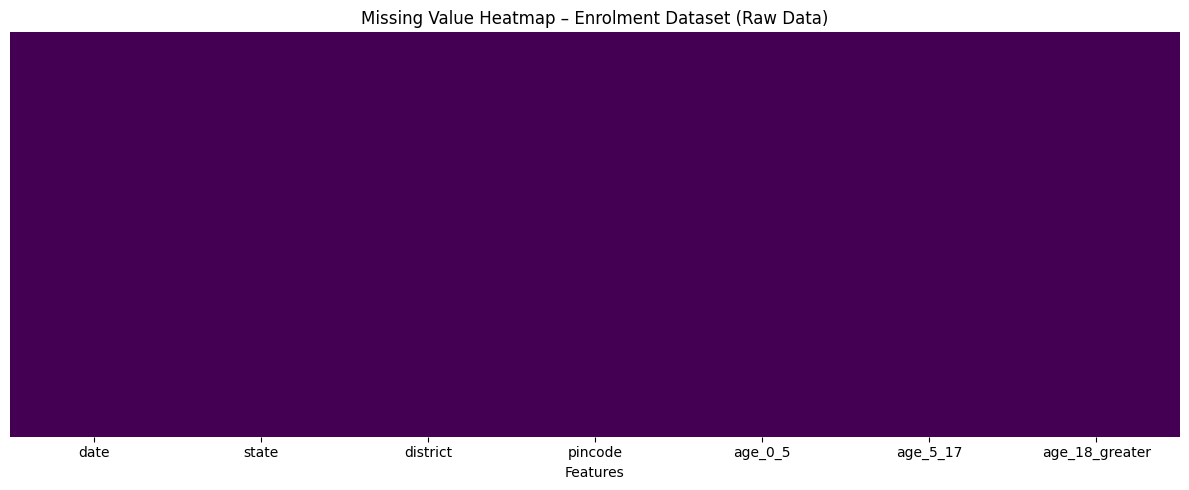

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def missing_heatmap(df, title, sample_size=500):
    sample_df = df.sample(min(len(df), sample_size), random_state=42)

    plt.figure(figsize=(12, 5))
    sns.heatmap(
        sample_df.isna(),
        cbar=False,
        yticklabels=False,
        cmap="viridis"
    )
    plt.title(f"Missing Value Heatmap – {title} (Raw Data)")
    plt.xlabel("Features")
    plt.tight_layout()
    plt.show()

missing_heatmap(biometric_df, "Biometric Dataset")
missing_heatmap(demographic_df, "Demographic Dataset")
missing_heatmap(enrolment_df, "Enrolment Dataset")


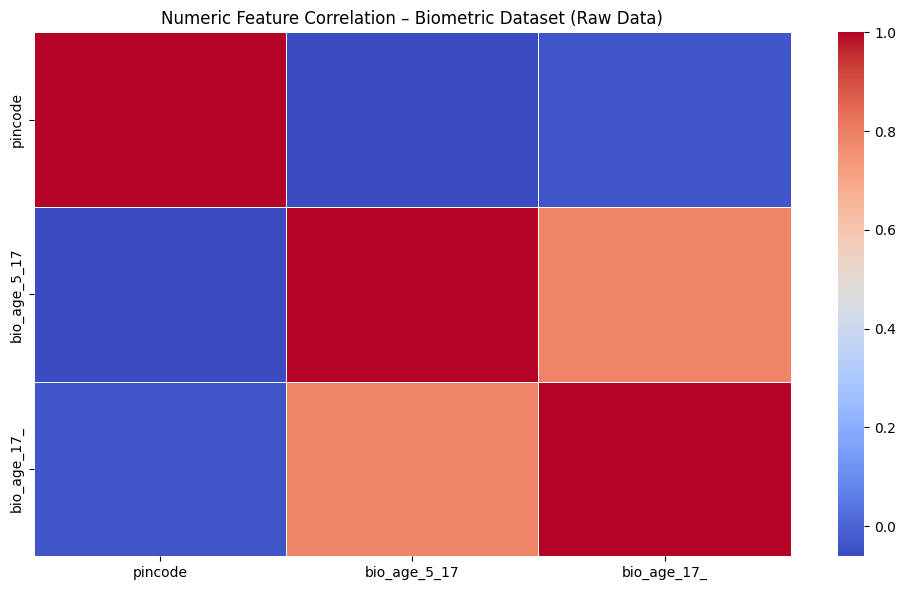

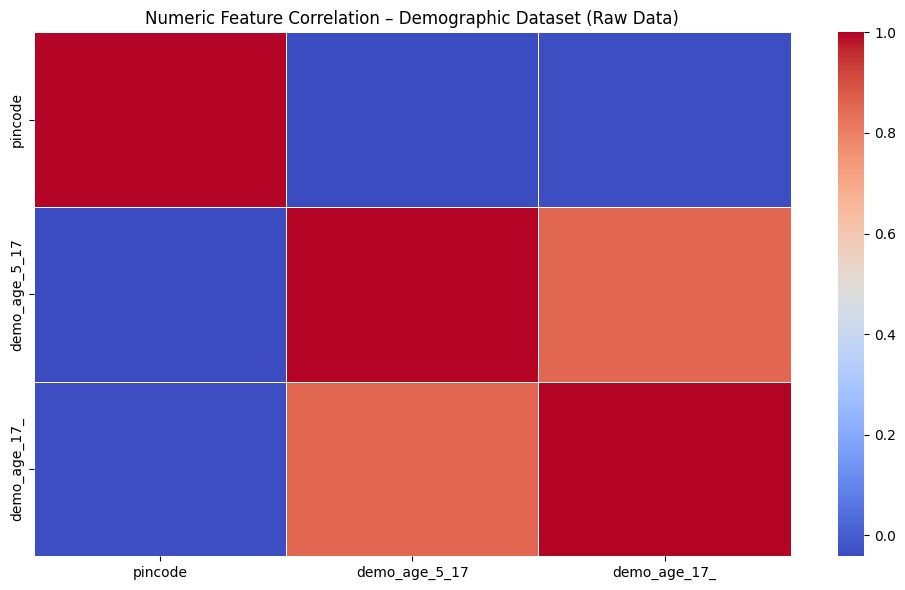

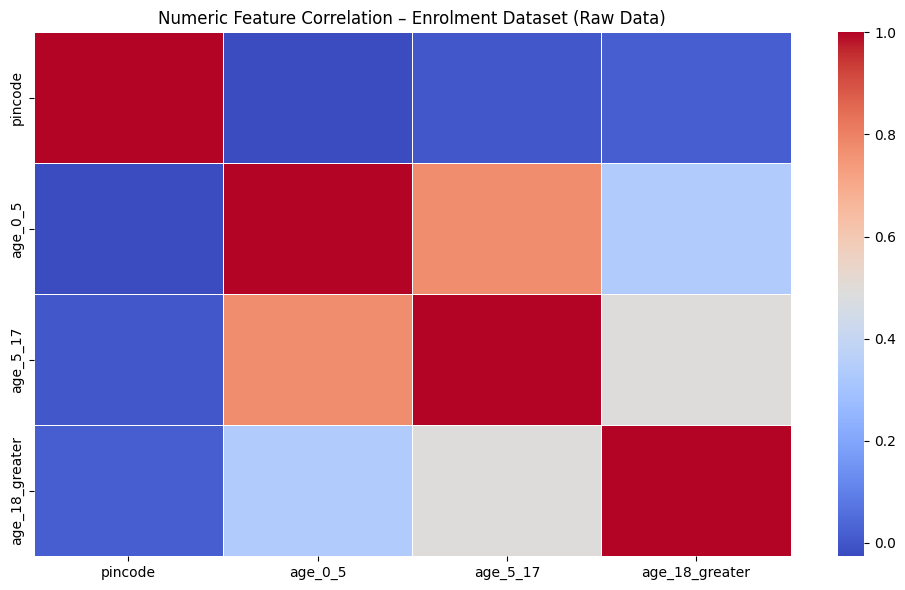

In [ ]:
def correlation_heatmap(df, title):
    num_df = df.select_dtypes(include="number")

    if num_df.shape[1] < 2:
        print(f"Not enough numeric columns for correlation heatmap in {title}")
        return

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        num_df.corr(),
        cmap="coolwarm",
        annot=False,
        linewidths=0.5
    )
    plt.title(f"Numeric Feature Correlation – {title} (Raw Data)")
    plt.tight_layout()
    plt.show()

correlation_heatmap(biometric_df, "Biometric Dataset")
correlation_heatmap(demographic_df, "Demographic Dataset")
correlation_heatmap(enrolment_df, "Enrolment Dataset")


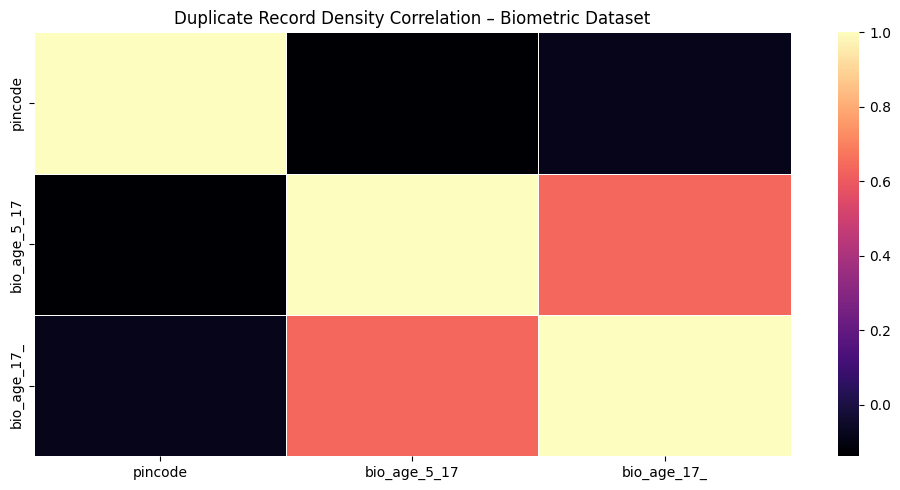

In [ ]:
def duplicate_density_heatmap(df, title):
    dup_mask = df.duplicated(keep=False)
    dup_df = df[dup_mask].select_dtypes(include="number")

    if dup_df.empty or dup_df.shape[1] < 2:
        print(f"No sufficient duplicate numeric data for {title}")
        return

    plt.figure(figsize=(10, 5))
    sns.heatmap(
        dup_df.corr(),
        cmap="magma",
        linewidths=0.5
    )
    plt.title(f"Duplicate Record Density Correlation – {title}")
    plt.tight_layout()
    plt.show()

duplicate_density_heatmap(biometric_df, "Biometric Dataset")
